In [1]:
from itertools import repeat
from ast import literal_eval
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import gzip
import pickle
from wyckoff_transformer.evaluation import StatisticalEvaluator
dataset = "mp_20"
with gzip.open(Path("cache", dataset, "data.pkl.gz"), "rb") as f:
    datasets_pd = pickle.load(f)
evaluator = StatisticalEvaluator(datasets_pd["test"], pd.concat([datasets_pd["train"], datasets_pd["val"]], axis=0))

In [3]:
mp_20_full = pd.concat(datasets_pd.values(), axis=0)

In [4]:
aug_counts = mp_20_full.sites_enumeration_augmented.map(len)

In [5]:
(aug_counts < 10).sum() / len(aug_counts)

0.9632757743925358

In [6]:
(aug_counts == 1).sum() / len(aug_counts)

0.12898803864777023

In [7]:
save_path = Path("plots/AI4AM_NeurIPS_2024")

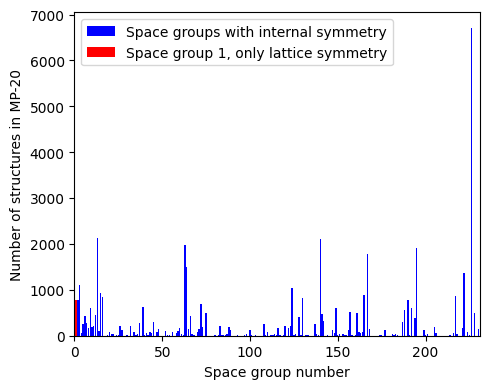

In [8]:
fig, ax = plt.subplots(figsize=(5, 4))
present_groups, structure_counts_indexed = np.unique(mp_20_full.spacegroup_number, return_counts=True)
structure_counts = np.zeros(231, dtype=int)
structure_counts[present_groups] = structure_counts_indexed
groups_symm = ax.bar(range(2, 232), structure_counts[1:], color="b")
group_1 = ax.bar(1, structure_counts[1], color="r")
ax.set_xlim(0, 231)
ax.set_xlabel("Space group number")
ax.set_ylabel("Number of structures in MP-20")
ax.legend([groups_symm, group_1], ["Space groups with internal symmetry", "Space group 1, only lattice symmetry"])
fig.tight_layout()
fig.savefig(save_path / "mp_20_space_group_distribution.pdf")

In [9]:
1 - structure_counts[1]/structure_counts.sum()

0.9827323177607288

In [10]:
structure_counts[1]

781

In [11]:
GENERATED_PATH = Path("generated")
with gzip.open(GENERATED_PATH / f"WyckoffTransformer_{dataset}.json.gz", "rt") as f:
    generated_wyckoff_transformer = json.load(f)
with gzip.open(GENERATED_PATH / f"DiffCSP_{dataset}.sites.json.gz", "rt") as f:
    generated_diffcsp = json.load(f)
with gzip.open(GENERATED_PATH / f"CrystalFormer_{dataset}.sites.json.gz", "rt") as f:
    generated_crystalformer = json.load(f)

In [12]:
generated_crystalformer = [x for x in generated_crystalformer if x is not None]
print(len(generated_crystalformer))

991


In [23]:
print("Test novelty: ",evaluator.get_test_novelty())
print("WyckoffTransformer novelty: ", evaluator.count_novel(generated_wyckoff_transformer))
print("DiffCSP novelty: ", evaluator.count_novel(generated_diffcsp))
print("CrystalFormer novelty: ", evaluator.count_novel(generated_crystalformer))
novel_wyckoff_transformer = evaluator.get_novel(generated_wyckoff_transformer)
novel_diff_csp, diff_csp_index = evaluator.get_novel(generated_diffcsp, return_index=True)
novel_crystalformer, crystalformer_index = evaluator.get_novel(generated_crystalformer, return_index=True)

Test novelty:  0.9556710148131771
WyckoffTransformer novelty:  0.8781
DiffCSP novelty:  0.862086208620862
CrystalFormer novelty:  0.7386478304742684


In [24]:
novel_evaluator = StatisticalEvaluator(evaluator.get_novel_dataframe(datasets_pd["test"]),
                                       pd.concat([datasets_pd["train"], datasets_pd["val"]], axis=0))

In [25]:
len(novel_evaluator.test_dataset)

9046

In [26]:
from wyckoff_transformer.evaluation import (
    timed_smact_validity_from_record, StatisticalEvaluator,
    smac_validity_from_counter)
smact_validity_test = sum(map(smac_validity_from_counter, datasets_pd["test"]["composition"]))/len(datasets_pd["test"])
print("Test SMAC-T: ", smact_validity_test)

datasets = {
   # "DiffCSP": (generated_diffcsp, evaluator),
   # "WyckoffTransformer": (generated_wyckoff_transformer, evaluator),
    "DiffCSP Novel": (novel_diff_csp, novel_evaluator),
    "WyckoffTransformer Novel": (novel_wyckoff_transformer, novel_evaluator),
    "CrystalFormer Novel": (novel_crystalformer, novel_evaluator)}
for name, (dataset, this_evaluator) in datasets.items():
    print(name)
    smact_validity = sum(map(timed_smact_validity_from_record, dataset))/len(dataset)
    print("SMAC-T validity: ", smact_validity)
    print("Num sites KS: ", this_evaluator.get_num_sites_ks(dataset))
    print("Num elements KS :", this_evaluator.get_num_elements_ks(dataset))
    print("DoF KS: ", this_evaluator.get_dof_ks(dataset))
    sg_chi2 = this_evaluator.get_sg_chi2(dataset, sample_size="test")
    print(f"SG chi2: statistic={sg_chi2.statistic}, pvalue={sg_chi2.pvalue}")
    elements_chi2 = this_evaluator.get_elements_chi2(dataset, sample_size="test")
    print(f"Elements chi2: statistic={elements_chi2.statistic}, pvalue={elements_chi2.pvalue}")

Test SMAC-T:  0.9104576608445721
DiffCSP Novel
SMAC-T validity:  0.8243619489559165
Num sites KS:  KstestResult(statistic=0.4118588005722748, pvalue=0.0, statistic_location=7, statistic_sign=1)
Num elements KS : KstestResult(statistic=0.18519767232495116, pvalue=9.464339965115635e-133, statistic_location=3, statistic_sign=1)


Generated dataset has extra space groups compared to test


DoF KS:  KstestResult(statistic=0.37485630289733374, pvalue=0.0, statistic_location=15, statistic_sign=1)
SG chi2: statistic=7169.899421589362, pvalue=0.0


Generated dataset has extra elements compared to test


Elements chi2: statistic=6095.5780085199785, pvalue=0.0
WyckoffTransformer Novel


Generated dataset has extra space groups compared to test


SMAC-T validity:  0.8188133469992028
Num sites KS:  KstestResult(statistic=0.035657732160086865, pvalue=2.31690210361006e-05, statistic_location=4, statistic_sign=1)
Num elements KS : KstestResult(statistic=0.050378202107272244, pvalue=2.847600693305831e-10, statistic_location=3, statistic_sign=1)
DoF KS:  KstestResult(statistic=0.04855516716078166, pvalue=1.4249449226388367e-09, statistic_location=2, statistic_sign=1)
SG chi2: statistic=242.23802117019613, pvalue=1.1681825398144444e-05


Generated dataset has extra elements compared to test


Elements chi2: statistic=1518.4971373736198, pvalue=1.305161308310121e-260
CrystalFormer Novel
SMAC-T validity:  0.8278688524590164
Num sites KS:  KstestResult(statistic=0.11077987553596735, pvalue=1.0764224864367019e-07, statistic_location=4, statistic_sign=1)
Num elements KS : KstestResult(statistic=0.11449857377411626, pvalue=3.4321464542620485e-08, statistic_location=3, statistic_sign=1)
DoF KS:  KstestResult(statistic=0.08820672482720376, pvalue=4.9119799691340086e-05, statistic_location=2, statistic_sign=1)
SG chi2: statistic=194.70968413271032, pvalue=0.01924063796044677
Elements chi2: statistic=1405.1900114525956, pvalue=2.0301510203535264e-237


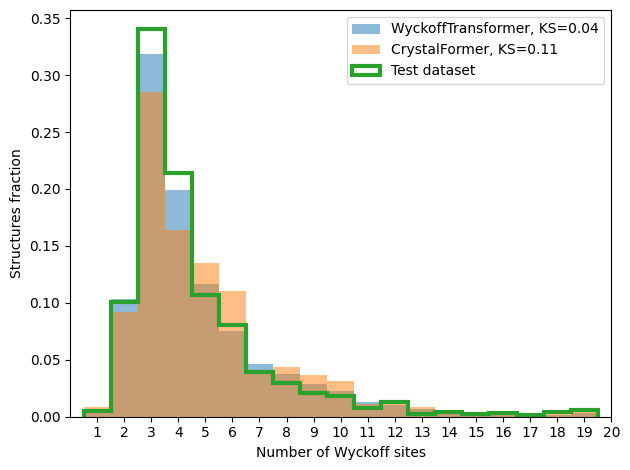

In [28]:
fig, ax = plt.subplots()
num_sites_wt_ks, num_sites_wt = novel_evaluator.get_num_sites_ks(novel_wyckoff_transformer, return_counts=True)
num_sites_wc_ks, num_sites_wc = novel_evaluator.get_num_sites_ks(novel_diff_csp, return_counts=True)
num_sites_cf_ks, num_sites_cf = novel_evaluator.get_num_sites_ks(novel_crystalformer, return_counts=True)
num_sites_test = novel_evaluator.test_dataset['site_symmetries'].map(len)
bins = list(range(1, 21))
ax.hist(num_sites_wt, bins=bins, density=True, alpha=0.5, label=f"WyckoffTransformer, KS={num_sites_wt_ks.statistic:.2f}",
    align='left', histtype='stepfilled')
#ax.hist(num_sites_wc, bins=bins, density=True, alpha=0.5, label=f"DiffCSP, KS={num_sites_wc_ks.statistic:.2f}", align='left')
ax.hist(num_sites_cf, bins=bins, density=True, alpha=0.5, label=f"CrystalFormer, KS={num_sites_cf_ks.statistic:.2f}", align='left')
ax.hist(num_sites_test, bins=bins, histtype='step', lw=3, density=True, label="Test dataset", align='left')
ax.legend()
ax.set_xlabel("Number of Wyckoff sites")
ax.set_ylabel("Structures fraction")
ax.set_xlim(0, 20)
ax.set_xticks(bins)
fig.tight_layout()
fig.savefig(save_path / "DiffCSP_num_sites_distribution.pdf")

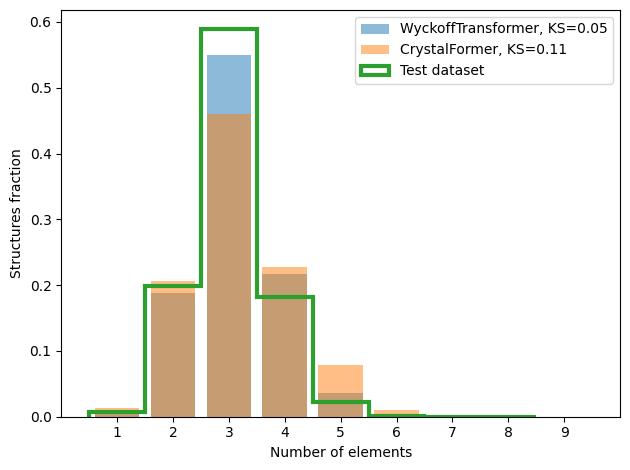

In [29]:
fig, ax = plt.subplots()
num_elements_wt_ks, num_elements_wt = novel_evaluator.get_num_elements_ks(novel_wyckoff_transformer, return_counts=True)
num_elements_wc_ks, num_elements_wc = novel_evaluator.get_num_elements_ks(novel_diff_csp, return_counts=True)
num_elements_cf_ks, num_elements_cf = novel_evaluator.get_num_elements_ks(novel_crystalformer, return_counts=True)
num_elements_test = novel_evaluator.test_dataset['composition'].map(len)
bins = list(range(1, 10))
ax.hist(num_elements_wt, bins=bins, density=True, alpha=0.5,
    label=f"WyckoffTransformer, KS={num_elements_wt_ks.statistic:.2f}", histtype='bar', rwidth=0.8, align='left')
#ax.hist(num_elements_wc, bins=bins, density=True, alpha=0.5,
#    label=f"DiffCSP, KS={num_elements_wc_ks.statistic:.2f}", histtype='bar', rwidth=0.8, align='left')
ax.hist(num_elements_cf, bins=bins, density=True, alpha=0.5,
    label=f"CrystalFormer, KS={num_elements_cf_ks.statistic:.2f}", histtype='bar', rwidth=0.8, align='left')
ax.hist(num_elements_test, bins=bins, histtype='step', lw=3, density=True, label="Test dataset",
    align='left')
ax.legend()
ax.set_xlabel("Number of elements")
ax.set_ylabel("Structures fraction")
ax.set_xlim(0, 10)
ax.set_xticks(range(1, 10))
fig.tight_layout()
fig.savefig(save_path / "DiffCSP_num_elements_distribution.pdf")

In [43]:
len(novel_wyckoff_transformer)

8781

In [42]:
len(novel_crystalformer)

732

Generated dataset has extra elements compared to test
Generated dataset has extra elements compared to test


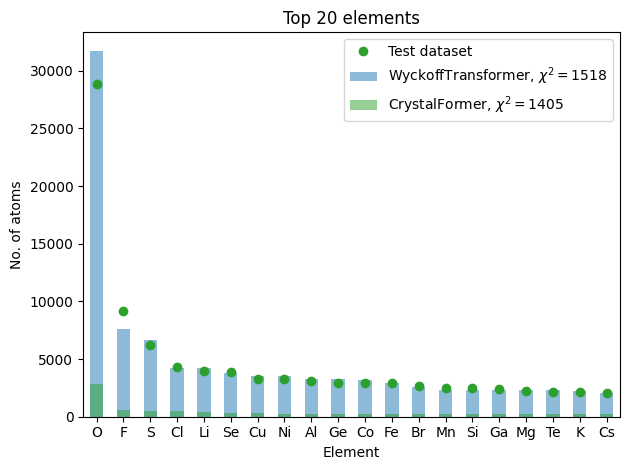

In [32]:
fig, ax = plt.subplots()
elements_wt_chi2, elements_wt, elements_test = \
    novel_evaluator.get_elements_chi2(novel_wyckoff_transformer, sample_size="test", return_counts=True)
elements_wc_chi2, elements_wc, _ = \
    novel_evaluator.get_elements_chi2(novel_diff_csp, sample_size="test", return_counts=True)
elements_cf_chi2, elements_cf, _ = \
    novel_evaluator.get_elements_chi2(novel_crystalformer, sample_size="test", return_counts=True)
elements_wt.sort_values(inplace=True, ascending=False)
n_elements_to_plot = 20
elements_wt.iloc[:n_elements_to_plot].plot(kind='bar', ax=ax, alpha=0.5,
    label=f"WyckoffTransformer, $\\chi^2={elements_wt_chi2.statistic:.0f}$")
#elements_wc.sort_values(ascending=False).iloc[:n_elements_to_plot].plot(kind='bar', ax=ax, alpha=0.5,
#    label=f"DiffCSP, $\\chi^2={elements_wc_chi2.statistic:.0f}$", color='tab:orange')
elements_cf.sort_values(ascending=False).iloc[:n_elements_to_plot].plot(kind='bar', ax=ax, alpha=0.5,
    label=f"CrystalFormer, $\\chi^2={elements_cf_chi2.statistic:.0f}$", color='tab:green')
elements_test.sort_values(ascending=False).iloc[:n_elements_to_plot].plot(kind='line',
    ax=ax, label="Test dataset", style='o', color='tab:green')
ax.set_xlabel("Element")
ax.set_ylabel("No. of atoms")
ax.set_title(f"Top {n_elements_to_plot} elements")
ax.legend()
fig.tight_layout()
fig.savefig(save_path / "DiffCSP_elements_distribution.pdf")